# SpaCy Tutorial
#### 03 Advanced spaCy

In [1]:
%matplotlib inline
import spacy
from spacy.gold import GoldParse
from spacy.scorer import Scorer
from spacy.util import decaying, minibatch, compounding
import pandas as pd
import numpy as np
import random
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot.plotters as skplt

## Using GPU  
To use GPU, install spaCy for the right CUDA version. The GPU version of spaCy utilizes [CuPy](http://learningsys.org/nips17/assets/papers/paper_16.pdf), a GPU-accelerated NumPy-like library.

In [2]:
# !pip install -U spacy[cuda100]

In [3]:
# Make sure GPU is enabled
spacy.prefer_gpu()

True

In [4]:
# Use the first GPU card
spacy.util.use_gpu(0)

<CUDA Device 0>

## Model Training

SpaCy allows training new models or retraining existing models. This is especially useful for text classifier and named entity recognizer. 

1. Initialize the model weights randomly with `nlp.begin_training`
2. Predict a few examples with the current weights by calling `nlp.update`
3. Compare prediction with true labels
4. Calculate how to change weights to improve predictions
5. Update weights slightly
6. Repeat 2-5

Here, we'll train an NER model.

![model_training](img/model_training.png)  

Here, we'll train NER using [conll2003 data](https://github.com/Hironsan/anago/raw/master/data/conll2003/en/ner/).

In [5]:
# !wget https://github.com/Hironsan/anago/raw/master/data/conll2003/en/ner/train.txt -P data
# !wget https://github.com/Hironsan/anago/raw/master/data/conll2003/en/ner/valid.txt -P data
# !wget https://github.com/Hironsan/anago/raw/master/data/conll2003/en/ner/test.txt -P data

### Convert conll2003 annotation to spaCy format

In [6]:
def convert_conll_to_spacy(filename:str=None):
    try:
        f=open(filename, 'r')
        
        all_data_list = []
        document = ''
        start = 0
        data_tuple = ()
        label_dict = {}
        entity_list = []

        for line_num, line in enumerate(f, 1):
            if line == '\n':
                all_data_list.append((document, {"entities": entity_list}))
                document = ''
                start = 0
                data_tuple = ()
                label_dict = {}
                entity_list = []

            if line != '\n':
                word, entity = line.split('\t')
                document += word.strip() + " "
                entity = entity.strip()

                if entity != 'O':
                    entity = entity.split("-")[1]
                    start_position = start
                    end_position = start + len(word)
                    entity_list.append((start_position, end_position, entity))

                start+=len(word)+1
    except:
        print("Something went wrong")
        return None
    return all_data_list

In [7]:
train_data = convert_conll_to_spacy('data/train.txt')
val_data = convert_conll_to_spacy('data/valid.txt')
test_data = convert_conll_to_spacy('data/test.txt')

In [8]:
len(train_data), len(val_data), len(test_data)

(14041, 3250, 3453)

### Train NER

In [9]:
random.seed(0)

nlp = spacy.blank("en")
ner = nlp.create_pipe("ner")
nlp.add_pipe(ner)

# Converts to BILUO scheme
for _, annotations in train_data:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])

# Adam (1e-3, beta1=0.9, beta2-0.999, L2=1e-6)
optimizer = nlp.begin_training(device=0)
    
distinct_entities = list(ner.move_names)

# get names of other pipes to disable them during training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]

In [10]:
distinct_entities

['O',
 'B-ORG',
 'I-ORG',
 'L-ORG',
 'U-ORG',
 'B-MISC',
 'I-MISC',
 'L-MISC',
 'U-MISC',
 'B-PER',
 'I-PER',
 'L-PER',
 'U-PER',
 'B-LOC',
 'I-LOC',
 'L-LOC',
 'U-LOC']

In [11]:
# Evaluation function
def evaluate_ner(nlp:spacy.lang.en.English=None, val_data:list=None):
    scorer = Scorer()
    
    for text, annotation in val_data:
        doc = nlp(text)
        gold = GoldParse(doc, entities=annotation['entities'])
        scorer.score(doc, gold)
        
    return scorer.scores

In [12]:
def train_ner(n_epoch:int=5, train_data:list=None, val_data:list=None, max_batch_size:int=32):
    with nlp.disable_pipes(*other_pipes):  # only train NER
        train_stats = []
        dropout = decaying(0.5, 0.2, 0.3) # Gradually decrease dropout rate from 0.5 to 0.2
        batch_size = compounding(4.0, max_batch_size, 1.001)
        
        for epoch in range(n_epoch):
            random.shuffle(train_data)
            batches = minibatch(train_data, size=batch_size)
            losses = {}

            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(
                    texts, 
                    annotations, 
                    drop = next(dropout),
                    sgd = optimizer,
                    losses=losses)
            
            print(f"Epoch: {epoch+1}")
            print(f"Losses: {losses}")
            val_score = evaluate_ner(nlp, val_data)
            print(val_score)

            train_stats.append(losses)
            train_stats.append(val_score)

In [13]:
train_ner(n_epoch=20, train_data=train_data, val_data=val_data, max_batch_size=128)

Losses {'ner': 15661.537846056572}
{'uas': 0.0, 'las': 0.0, 'las_per_type': {'': {'p': 0.0, 'r': 0.0, 'f': 0.0}}, 'ents_p': 86.15148292567648, 'ents_r': 84.74950598628385, 'ents_f': 85.44474393530997, 'ents_per_type': {'ORG': {'p': 77.28888888888889, 'r': 83.1261950286807, 'f': 80.10133578995855}, 'LOC': {'p': 85.30915853091585, 'r': 87.6313276026743, 'f': 86.45465253239105}, 'PER': {'p': 93.6266020090059, 'r': 85.83677357891393, 'f': 89.56262425447315}, 'MISC': {'p': 86.29787234042553, 'r': 79.96845425867508, 'f': 83.01268931641424}}, 'tags_acc': 0.0, 'token_acc': 100.0, 'textcat_score': 0.0, 'textcats_per_cat': {}}
Losses {'ner': 7101.599814165207}
{'uas': 0.0, 'las': 0.0, 'las_per_type': {'': {'p': 0.0, 'r': 0.0, 'f': 0.0}}, 'ents_p': 89.13430708941931, 'ents_r': 87.24863419737301, 'ents_f': 88.18139097744361, 'ents_per_type': {'PER': {'p': 92.815344603381, 'r': 90.66370276278184, 'f': 91.72690763052209}, 'ORG': {'p': 85.4608181370133, 'r': 82.88718929254301, 'f': 84.15433147294345}

In [14]:
# Evaluate on val set
evaluate_ner(nlp, val_data)

{'uas': 0.0,
 'las': 0.0,
 'las_per_type': {'': {'p': 0.0, 'r': 0.0, 'f': 0.0}},
 'ents_p': 90.62573789846518,
 'ents_r': 89.22468906195513,
 'ents_f': 89.91975634042055,
 'ents_per_type': {'PER': {'p': 91.18012422360249,
   'r': 93.23594791997459,
   'f': 92.19657717067044},
  'ORG': {'p': 88.46918489065607,
   'r': 85.08604206500956,
   'f': 86.74463937621833},
  'LOC': {'p': 91.64666346615459,
   'r': 91.16523400191022,
   'f': 91.40531481924828},
  'MISC': {'p': 90.99567099567099,
   'r': 82.88643533123027,
   'f': 86.7519603796946}},
 'tags_acc': 0.0,
 'token_acc': 100.0,
 'textcat_score': 0.0,
 'textcats_per_cat': {}}

In [ ]:
!mkdir -p model

In [15]:
# Save the model
nlp.to_disk('model/ner_v1')

In [16]:
# Weight averaging (https://www.aclweb.org/anthology/P04-1015/)
with nlp.use_params(optimizer.averages):
    nlp.to_disk('model/ner_v1_wa')

In [17]:
nlp_wa = nlp.from_disk('model/ner_v1_wa')

In [18]:
# Evaluate on val set
evaluate_ner(nlp_wa, val_data)

{'uas': 0.0,
 'las': 0.0,
 'las_per_type': {'': {'p': 0.0, 'r': 0.0, 'f': 0.0}},
 'ents_p': 90.86431335757007,
 'ents_r': 90.06160641636637,
 'ents_f': 90.46117921774665,
 'ents_per_type': {'PER': {'p': 92.58908861557869,
   'r': 93.23594791997459,
   'f': 92.91139240506328},
  'ORG': {'p': 87.93774319066148,
   'r': 86.4244741873805,
   'f': 87.17454194792673},
  'LOC': {'p': 90.96895578551269,
   'r': 92.35912129894938,
   'f': 91.65876777251182},
  'MISC': {'p': 91.14139693356049,
   'r': 84.38485804416403,
   'f': 87.63308763308764}},
 'tags_acc': 0.0,
 'token_acc': 100.0,
 'textcat_score': 0.0,
 'textcats_per_cat': {}}

In [19]:
# Evaluate on test set
evaluate_ner(nlp_wa, test_data)

{'uas': 0.0,
 'las': 0.0,
 'las_per_type': {'': {'p': 0.0, 'r': 0.0, 'f': 0.0}},
 'ents_p': 83.29101680570669,
 'ents_r': 84.92357001972387,
 'ents_f': 84.09937129951778,
 'ents_per_type': {'PER': {'p': 88.78470970068518,
   'r': 88.78470970068518,
   'f': 88.78470970068518},
  'LOC': {'p': 85.03778337531486,
   'r': 87.6883116883117,
   'f': 86.34271099744245},
  'ORG': {'p': 79.71360381861575,
   'r': 80.28846153846155,
   'f': 80.00000000000001},
  'MISC': {'p': 73.57357357357357,
   'r': 80.06535947712419,
   'f': 76.68231611893583}},
 'tags_acc': 0.0,
 'token_acc': 100.0,
 'textcat_score': 0.0,
 'textcats_per_cat': {}}

### Test (spot check)

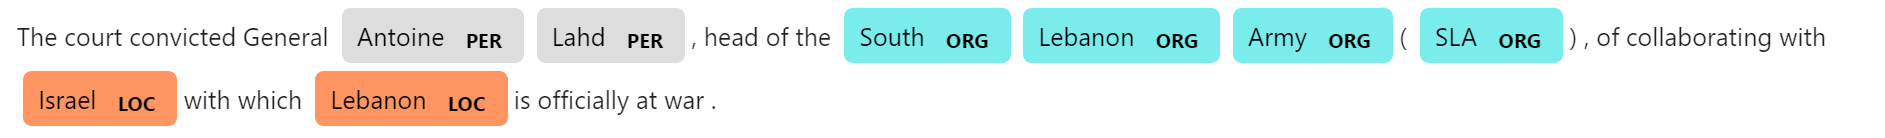

In [20]:
doc = [nlp(text) for text, annotation in [test_data[random.randint(0, len(test_data))]]][0]
spacy.displacy.render(doc, style='ent')

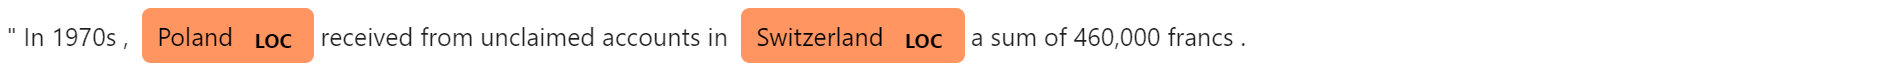

In [21]:
doc = [nlp(text) for text, annotation in [test_data[random.randint(0, len(test_data))]]][0]
spacy.displacy.render(doc, style='ent')

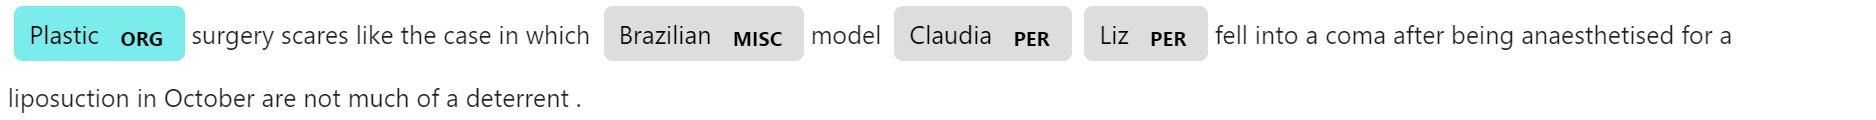

In [22]:
doc = [nlp(text) for text, annotation in [test_data[random.randint(0, len(test_data))]]][0]
spacy.displacy.render(doc, style='ent')

## Using Transformer-based models
`spacy-transformers` package provides spaCy model pipelines that wrap Hugging Face's [transformers package](https://github.com/huggingface/transformers) for convenient access to state-of-the-art transformer architectures, such as [BERT](https://arxiv.org/abs/1810.04805), [GPT-2](https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf), [XLNet](https://arxiv.org/abs/1906.08237), etc. Those models were pretrained on a massive amount of text using language models (LM).   

In this tutorial, we'll be using English BERT (uncased, large).


In [2]:
# !pip install spacy-transformers

In [3]:
# !python -m spacy download en_trf_bertbaseuncased_lg
# # Restart kernel after the model is downloaded

In [5]:
import torch

# Use CUDA tensor
if spacy.prefer_gpu():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")

# Load model
nlp = spacy.load("en_trf_bertbaseuncased_lg")

In [6]:
# Pipeline is different from normal spaCy
print(nlp.pipe_names)

['sentencizer', 'trf_wordpiecer', 'trf_tok2vec']


### Similarity check  
Unlike normal word vectors, LM-based models like BERT return contextualized word vectors.  This feature hooks to existing spaCy's `similarity` method. 

Similarly, you can hook your own model (e.g. `Natural Language Inference` (entailment, neutral, contradiction)) that was trained in another ML framework like TensorFlow, to spaCy's `similarity` method.

In [7]:
apple1 = nlp("Apple shares rose on the news.")
apple2 = nlp("Apple sold fewer iPhones this quarter.")
apple3 = nlp("Apple pie is delicious.")
print(apple1[0].similarity(apple2[0]))  # Both refer to Apple (company)
print(apple1[0].similarity(apple3[0]))  # Apple (company) and Apple (food)

0.7342854
0.43365765


In [8]:
# Sentence-level similarity
apple1.similarity(apple3)

array(0.54049635, dtype=float32)

In [9]:
# (num_wordpieces_tokens, vector_size)
# [CLS] token embedding can be retrieved by trf_last_hidden_state[0]  
apple1._.trf_last_hidden_state.shape, apple2._.trf_last_hidden_state.shape, apple3._.trf_last_hidden_state.shape,

((9, 768), (10, 768), (7, 768))

In [10]:
# print wordpieces
print(apple2._.trf_word_pieces_)

['[CLS]', 'apple', 'sold', 'fewer', 'iphone', '##s', 'this', 'quarter', '.', '[SEP]']


### Transfer Learning  
The pretrained transformer models can be also used for transfer learning. Similar to computer vision's pretrained models (e.g. ResNet, Inception), you can start training on your smaller dataset with labels specific to your problem. Fine-tuning (changing the weights of the pretrained models) is possible by `nlp.update`.  

Transfer learning is only available for pre-defined spaCy's pipelines (for `spacy-transformers`, only `trf_textcat`), so it cannot be used for other unrelated tasks like reading comprehension.

In [11]:
from spacy.util import minibatch
import spacy_transformers
from spacy_transformers.util import cyclic_triangular_rate
from sklearn.model_selection import train_test_split

In [12]:
df = pd.read_csv('data/train.csv.zip', sep=',', compression='zip', encoding='latin_1')
df.shape

(99989, 3)

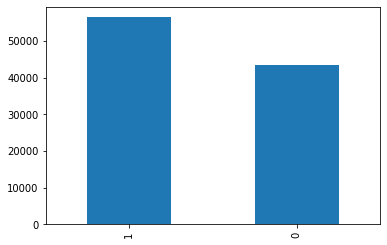

In [13]:
# Slighly imbalanced data
df.Sentiment.value_counts().plot(kind="bar");

In [14]:
#Splitting to train+val and test
trainval_X, test_X, trainval_y, test_y = train_test_split(df[['SentimentText']], df[['Sentiment']].values,
                                                test_size = .15,
                                                random_state=1234)

In [15]:
trainval_X['Sentiment'] = trainval_y

#Splitting to train and val
train_X, val_X, train_y, val_y = train_test_split(trainval_X[['SentimentText']], trainval_X[['Sentiment']].values,
                                                  test_size = .18,
                                                  random_state=1)

In [16]:
train_X.shape, val_X.shape, test_X.shape

((69691, 1), (15299, 1), (14999, 1))

In [17]:
def prepare_data(data_X:pd.DataFrame=None, data_y:np.array=None, text_column:str='text'):
    labels = [{"1": bool(y), "0": not bool(y)} for y in data_y]
    texts = tuple(data_X[text_column].values.tolist())
    combined_data = list(zip(texts, [{"cats": cats} for cats in labels]))
    
    return combined_data, texts, labels

Padding is done automatically with subbatching, which regroups the batched sentences by sequence length, to minimise the amount of padding required. 

In [18]:
# Format data for spaCy
train_data, train_text, train_label = prepare_data(train_X, train_y, "SentimentText")
val_data, val_text, val_label = prepare_data(val_X, val_y, "SentimentText")
test_data, test_text, test_label = prepare_data(test_X, test_y, "SentimentText")

In [19]:
# Create a pipeline for text classification
textcat = nlp.create_pipe("trf_textcat", config={"exclusive_classes": True, "architecture": "softmax_class_vector"})
for label in ("1", "0"):
    textcat.add_label(label)
nlp.add_pipe(textcat, last=True)

In [20]:
# Evaluation function
def evaluate_classifier(nlp:spacy_transformers.language.TransformersLanguage=None, 
                        val_text:tuple=None, 
                        val_label:list=None, 
                        batch_size:int=32):
    proba_list = []
    label_list = []
    
    for i, doc in enumerate(nlp.pipe(val_text, batch_size=batch_size)):
        pred = doc.cats['1']
        label = 1.0 if val_label[i]['1'] else 0.0
        proba_list.append(pred)
        label_list.append(label)
    
    pred_indices = np.round(proba_list)
    accuracy = accuracy_score(label_list, pred_indices)
    roc_auc = roc_auc_score(label_list, proba_list)
    f1 = f1_score(label_list, pred_indices)
    precision = precision_score(label_list, pred_indices)
    recall = recall_score(label_list, pred_indices)
    
    return {'accuracy': accuracy, 'roc_auc': roc_auc, 'f1': f1, 'precision': precision, 'recall': recall}

In [21]:
# Optimizer (Adam)
optimizer = nlp.resume_training()
optimizer.alpha = 0.001
optimizer.trf_weight_decay = 0.005
optimizer.L2 = 0.0

In [22]:
def train_classifier(n_epoch:int=5, 
                     train_data:list=None, 
                     val_text:tuple=None, 
                     val_label:list=None, 
                     batch_size:int=32, 
                     lr:float=1e-3):
    train_stats = []
    dropout = decaying(0.2, 0.1, 0.3) # Gradually decrease dropout rate from 0.2 to 0.1
    # Cyclic triangular rate (https://arxiv.org/abs/1506.01186)
    learn_rates = cyclic_triangular_rate(
        lr / 3, lr * 3, 2 * len(train_data) // batch_size
    )

    for epoch in range(n_epoch):
        random.shuffle(train_data)
        batches = minibatch(train_data, size=batch_size)
        losses = {}

        for batch in batches:
            optimizer.trf_lr = next(learn_rates)
            texts, cats = zip(*batch)
            nlp.update(
                texts, 
                cats, 
                drop = next(dropout),
                sgd = optimizer,
                losses=losses)

        print(f"Epoch: {epoch+1}")
        print(f"Losses: {losses}")
        
        with nlp.use_params(optimizer.averages):
            val_score = evaluate_classifier(nlp, val_text, val_label, batch_size)

        print(val_score)

        train_stats.append(losses)
        train_stats.append(val_score)

In [23]:
train_classifier(n_epoch=5, train_data=train_data, val_text=val_text, val_label=val_label, batch_size=32, lr=2e-6)

Epoch: 1
Losses: {'trf_textcat': 0.740542416649987}
{'accuracy': 0.7903784561082424, 'roc_auc': 0.8687040302849849, 'f1': 0.8193341220212945, 'precision': 0.7986820428336079, 'recall': 0.8410825815405968}
Epoch: 2
Losses: {'trf_textcat': 0.6592710536715458}
{'accuracy': 0.8004444734949997, 'roc_auc': 0.8743129609314639, 'f1': 0.8263861245379585, 'precision': 0.8128425998433829, 'recall': 0.8403886190145732}
Epoch: 3
Losses: {'trf_textcat': 0.6218109232067945}
{'accuracy': 0.8072423034185241, 'roc_auc': 0.8829449608338314, 'f1': 0.8343537606021456, 'precision': 0.8110734956863601, 'recall': 0.8590099467962063}
Epoch: 4
Losses: {'trf_textcat': 0.586101518390933}
{'accuracy': 0.8087456696516112, 'roc_auc': 0.8840642835508836, 'f1': 0.8362252322847868, 'precision': 0.8101952277657267, 'recall': 0.8639833448993754}
Epoch: 5
Losses: {'trf_textcat': 0.5791687902383273}
{'accuracy': 0.8085495784038172, 'roc_auc': 0.8853615213060473, 'f1': 0.8355510639492449, 'precision': 0.8118930714675395, 'r

In [24]:
# Evaluate on val set
evaluate_classifier(nlp, val_text, val_label, 32)

{'accuracy': 0.8085495784038172,
 'roc_auc': 0.8853615213060473,
 'f1': 0.8355510639492449,
 'precision': 0.8118930714675395,
 'recall': 0.8606291926902614}

In [25]:
# Weight averaging (https://www.aclweb.org/anthology/P04-1015/)
with nlp.use_params(optimizer.averages):
    nlp.to_disk('model/bert_textcat_wa')
    
nlp_wa = nlp.from_disk('model/bert_textcat_wa')

In [26]:
# Evaluate on val set
evaluate_classifier(nlp, val_text, val_label, 32)

{'accuracy': 0.8096539769317954,
 'roc_auc': 0.8884111784230834,
 'f1': 0.8315534839813556,
 'precision': 0.8431442928930366,
 'recall': 0.8202770341054592}

In [27]:
# Evaluate on test set
evaluate_classifier(nlp_wa, test_text, test_label, 32)

{'accuracy': 0.8175211680778719,
 'roc_auc': 0.8917429357669111,
 'f1': 0.8439655663873212,
 'precision': 0.8270391061452514,
 'recall': 0.861599348155046}

In [28]:
# Predict function
def predict(nlp:spacy_transformers.language.TransformersLanguage=None, 
            val_text:tuple=None, 
            batch_size:int=32):
    
    proba_list = []
    
    for i, doc in enumerate(nlp.pipe(val_text, batch_size=batch_size)):
        pred = doc.cats['1']
        proba_list.append(pred)
    
    return proba_list

In [29]:
probas = predict(nlp_wa, test_text)
pred_indices = np.round(probas)

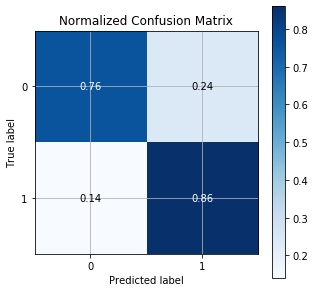

In [31]:
skplt.plot_confusion_matrix(test_y, pred_indices, figsize=(5,5), normalize=True);

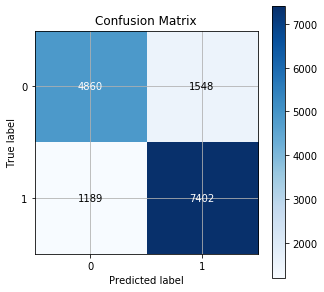

In [32]:
skplt.plot_confusion_matrix(test_y, pred_indices, figsize=(5,5), normalize=False);

In [36]:
# Calculate the best precision, recall, f1 score
def calc_prec_recall_f1(y_true:np.ndarray=None, y_pred:list=None):
    thresh_list = []
    thresholds = []
    for thresh in np.arange(0.01, 1.0, 0.01):
        thresh = np.round(thresh, 2)
        recall_res = recall_score(y_true, (y_pred > thresh).astype(int))
        prec_res = precision_score(y_true, (y_pred > thresh).astype(int))
        f1_res = f1_score(y_true, (y_pred > thresh).astype(int))
        thresh_list.append([thresh, recall_res, prec_res, f1_res])
        thresholds.append([thresh, recall_res, prec_res, f1_res])

    # Ordered by F-1 in descending
    thresholds.sort(key=lambda x: x[3], reverse=True)
    best_thresh = thresholds[0][0]
    best_recall = thresholds[0][1]
    best_prec = thresholds[0][2]
    best_f1 = thresholds[0][3]
    return  thresh_list, best_recall, best_prec, best_f1, best_thresh

In [37]:
thresh_list, best_recall, best_prec, best_f1, best_threshold = calc_prec_recall_f1(test_y, probas)
print(f'Optimal Recall: {best_recall} Precision: {best_prec} F1: {best_f1} at threshold: {best_threshold}')

Optimal Recall: 0.8837155162379234 Precision: 0.8138064101189838 F1: 0.8473214285714286 at threshold: 0.45


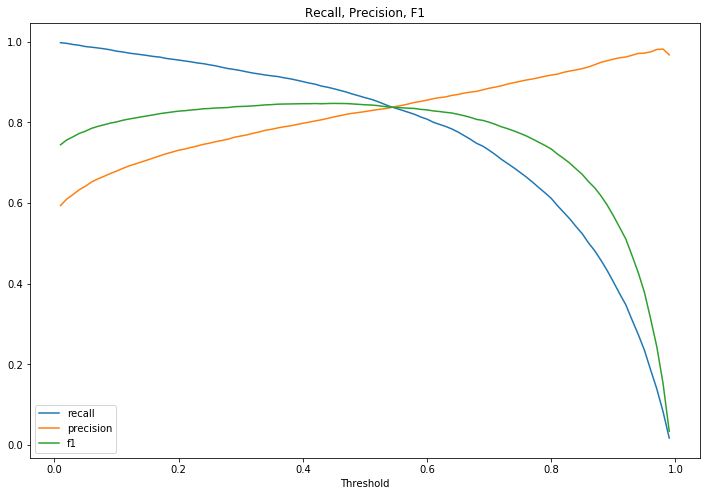

In [38]:
thresh_list = np.array(thresh_list)
threshold = thresh_list[:,0]
recall_list = thresh_list[:,1]
precision_list = thresh_list[:,2]
f1_list = thresh_list[:,3]

plt.figure(figsize = (12, 8))
plt.plot(threshold, recall_list, label='recall')
plt.plot(threshold, precision_list, label='precision')
plt.plot(threshold, f1_list, label='f1')
plt.title('Recall, Precision, F1')
plt.xlabel('Threshold')
plt.legend()
plt.show();

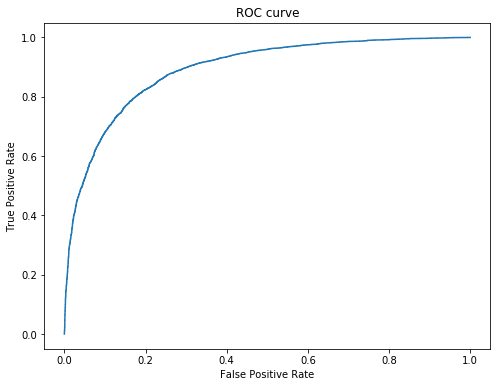

In [39]:
# ROC curve
fp, tp, thresholds = roc_curve(test_y, probas)

plt.figure(figsize = (8, 6))
plt.plot(fp, tp)
plt.title("ROC curve")
plt.xlabel( "False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show();

In [40]:
# Comparison between prediction and true label distribution
test_pd = pd.DataFrame(pred_indices, columns=['pred'])
test_pd['probas'] = probas

label_list = []

for i in test_label:
    label = 1.0 if i['1'] else 0.0
    label_list.append(label)
    
test_pd['label'] = label_list

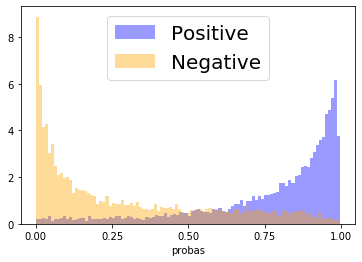

In [41]:
sns.distplot(test_pd[test_pd.label == 1].probas, kde=False, bins=100, color='blue', label='Positive', norm_hist=True)
sns.distplot(test_pd[test_pd.label == 0].probas, kde=False, bins=100, color='orange', label='Negative', norm_hist=True)

plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 10
plt.legend();

## Annotation by Prodigy  
[Prodigy](https://prodi.gy/) is an annotation tool that enables users to do annotation themselves via web browser. It's powered by active learning so you're asked to annotate examples that the model is unsure about. By default, it comes with **recipes** for text classification, NER, image classification, object detection, etc, but users can also build their own recipes.

***This is NOT open source, so license is required. For an open source option, [doccano](https://github.com/doccano/doccano) is recommended.

In [5]:
df = pd.read_csv('data/train.csv.zip', sep=',', compression='zip', encoding='latin_1')
df.shape

(99989, 3)

In [16]:
# Save only text column as csv format for annotation
df.SentimentText.to_csv("data/test_prodigy.csv", header=False, index=False)

### Run Prodigy  
1. Start the web app.  
2. Hit `localhost:8888` on your browser.  

### Use Prodigy for annotation
1. Use pre-trained spaCy model to start creating manually annotated data set (~1000):  
`prodigy ner.teach my_set en_core_web_lg data/test_prodigy.csv`
2. Train a model:  
`prodigy train ner my_set en_core_web_lg --output model/ner_v1 --n-iter 5 --eval-split 0.2 --dropout 0.2`
3. Iterate (`ner.correct` <-> `train`) until performance is satisfactory:  
`prodigy ner.correct my_set model/ner_v1 data/test_prodigy.csv`  
`prodigy train ner my_set model/ner_v1 --output model/ner_v2 --n-iter 5 --eval-split 0.2 --dropout 0.2`  
`prodigy ner.correct my_set model/ner_v2 data/test_prodigy.csv`  
...
4. Done. The trained model is compatible with spaCy.
5. Optionally, output the training data set as JSONL:  
`prodigy ner.gold-to-spacy my_set data/ner_gold.jsonl --biluo --spacy-model model/ner_v8`
6. You can use the annotated data to train in your favoriate ML framework. For example, the data can be converted to be used in AllenNLP.

In [ ]:
import json

with open('data/ner_gold.jsonl') as json_file:
    prodigy_gold = [json.loads(jline) for jline in json_file]
    
text_ner = []
for row in prodigy_gold:
    text = row[0]
    label = row[1]
    
    text_concat = ""
    counter = 0
    
    for token in text.split(" "):
        text_with_annotation = token + "#" + label[counter]
        text_concat = text_concat + text_with_annotation + " "
        counter += 1

    text_ner.append(text_concat.strip())


ner_pd = pd.DataFrame(text_ner, columns=['text'])

In [ ]:
# Split into train and val
train_X, val_X = train_test_split(ner_pd, test_size=0.2, random_state=1)

In [ ]:
# Save
train_X.to_csv("data/ner_train_allennlp.csv.bz2", compression='bz2', header=False, index=False)
val_X.to_csv("data/ner_val_allennlp.csv.bz2", compression='bz2', header=False, index=False)